In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import datetime
from pyfolio.timeseries import perf_stats
from utils import plot, rolling_sharpe, plot_rolling_sharpe, plot_rolling_vol
%matplotlib inline

In [2]:
cash = 80000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-08-31_11-41_20200101_20200831_base.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
micro_contracts = df[df.contract.str.startswith('M')]
macro_contracts = df[~df.contract.str.startswith('M')]
micro_contracts['amount'] /= 10
df = pd.concat([macro_contracts, micro_contracts]).sort_index()
df.contract = df.contract.str.strip('M')
df['contract'] = df['contract'].apply(lambda x: x[:2])
df.contract = df.contract.str.strip()

In [4]:
pnl = df.groupby('contract').realizedPNL.sum()
pnl['total'] = pnl.sum()
pnl

contract
ES        17775.24
GC        -4550.02
NQ        57963.44
YM        52097.64
total    123286.30
Name: realizedPNL, dtype: float64

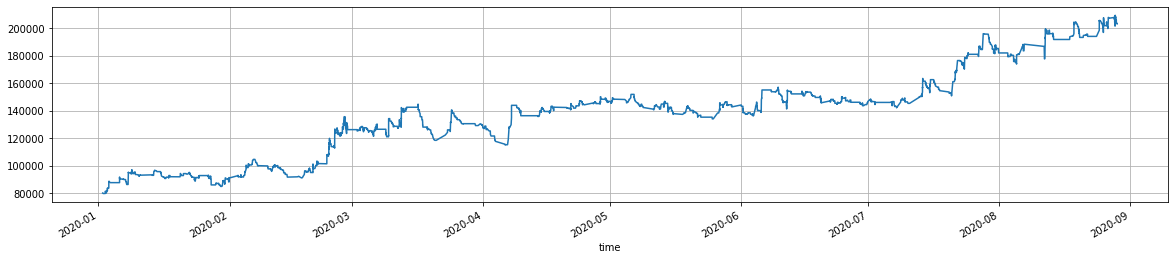

In [5]:
df.cash.plot(figsize=(20,4), grid=True);

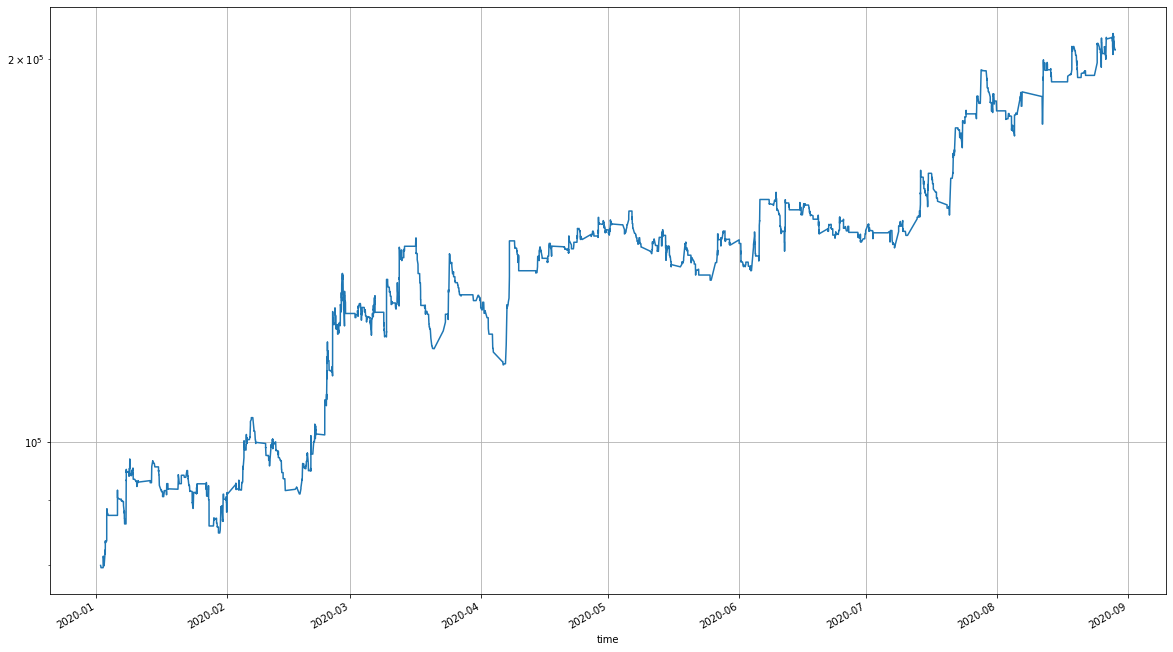

In [6]:
df.cash.plot(figsize=(20,12), grid=True, logy=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, aggfunc='sum', columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
#monthly average number of transactions
daily_count = df.groupby('contract').action.resample('B').count()
zero_index = set(daily_count.index.get_level_values(0))
monthly_count = daily_count.groupby('contract').resample('M', level=1).mean()
average_monthly_contracts = pd.DataFrame({contract: monthly_count[contract] for contract in zero_index})
average_monthly_contracts

,YM,NQ,GC,ES
time,,,,
2020-01-31,2.181818,11.636364,5.454545,2.100000
2020-02-29,4.600000,16.600000,7.200000,3.500000
2020-03-31,3.636364,10.545455,4.590909,1.727273
2020-04-30,1.818182,7.727273,1.954545,1.454545
2020-05-31,2.285714,8.571429,2.952381,1.809524
2020-06-30,2.545455,10.636364,2.818182,2.272727
2020-07-31,2.260870,9.478261,3.913043,2.000000
2020-08-31,1.300000,8.400000,5.200000,1.500000


In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     346
 GC     726
 NQ    1790
 YM     442
 Name: action, dtype: int64,
 3304)

In [10]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES     2.011628
 GC     4.220930
 NQ    10.406977
 YM     2.569767
 Name: action, dtype: float64,
 19.209302325581394)

In [11]:
# commission paid
comm = df.groupby('contract').commission.sum()
comm['total'] = comm.sum()
comm

contract
ES         945.91
GC        2600.02
NQ        5228.06
YM        1407.11
total    10181.10
Name: commission, dtype: float64

In [12]:
# commission paid as percent of pnl
round((comm/pnl) *100, 1)

contract
ES        5.3
GC      -57.1
NQ        9.0
YM        2.7
total     8.3
dtype: float64

In [13]:
# per trade stats (pro rated per macro contract)
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss', 
                                'win_ratio', 'EV/contract', 'number_of_contracts'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    d['pnl_per_contract'] = d.realizedPNL / d.amount
    row['average_PNL'] = round(d['pnl_per_contract'].mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0])['pnl_per_contract'].mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0])['pnl_per_contract'].mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV/contract'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_contracts'] = d.amount.sum()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV/contract,number_of_contracts
NQ,0.41,53.65,777.18,-449.26,1.73,53.58,984.9
GC,0.34,32.60,1220.20,-583.57,2.09,29.71,468.7
YM,0.46,166.47,1327.12,-836.80,1.59,158.60,261.4
ES,0.42,98.84,1478.99,-894.86,1.65,102.16,158.9
total,0.40,68.77,1020.12,-573.51,1.78,63.94,1873.9


In [14]:
edge = results['win_ratio'] - ((1-results['success_rate'])/ results['success_rate'])
edge

NQ       0.290976
GC       0.148824
YM       0.416087
ES       0.269048
total    0.280000
dtype: float64

In [15]:
daily = by_contract.resample('B').sum()
total_cumsum = (daily['total'].cumsum() + cash).shift(1).fillna(cash)
daily_non_total = daily[daily.columns.drop('total')] * len(daily.columns.drop('total'))
daily_scaled = daily_non_total.copy()
daily_scaled['total'] = daily['total']
daily_scaled

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-02,0.00,-4231.92,4032.24,0.00,-49.92
2020-01-03,0.00,14292.32,10836.24,5403.84,7633.10
2020-01-06,0.00,10616.72,-1350.56,0.00,2316.54
2020-01-07,-3280.64,-3521.04,-2972.32,-4865.92,-3659.98
2020-01-08,-2296.88,25152.96,6730.96,1878.16,7866.30
...,...,...,...,...,...
2020-08-24,0.00,0.00,26438.08,19717.76,11538.96
2020-08-25,25062.08,-45792.80,-11871.36,17766.48,-3708.90
2020-08-26,0.00,-9956.16,31468.00,0.00,5377.96


In [16]:
returns = daily.divide(total_cumsum, axis=0)
returns

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-02,0.000000,-0.013225,0.012601,0.000000,-0.000624
2020-01-03,0.000000,0.044691,0.033884,0.016898,0.095473
2020-01-06,0.000000,0.030305,-0.003855,0.000000,0.026450
2020-01-07,-0.009123,-0.009792,-0.008266,-0.013532,-0.040712
2020-01-08,-0.006658,0.072916,0.019512,0.005445,0.091214
...,...,...,...,...,...
2020-08-24,0.000000,0.000000,0.034046,0.025392,0.059437
2020-08-25,0.030463,-0.055662,-0.014430,0.021595,-0.018033
2020-08-26,0.000000,-0.012324,0.038952,0.000000,0.026628


In [17]:
returns_scaled = daily_scaled.divide(total_cumsum, axis=0)

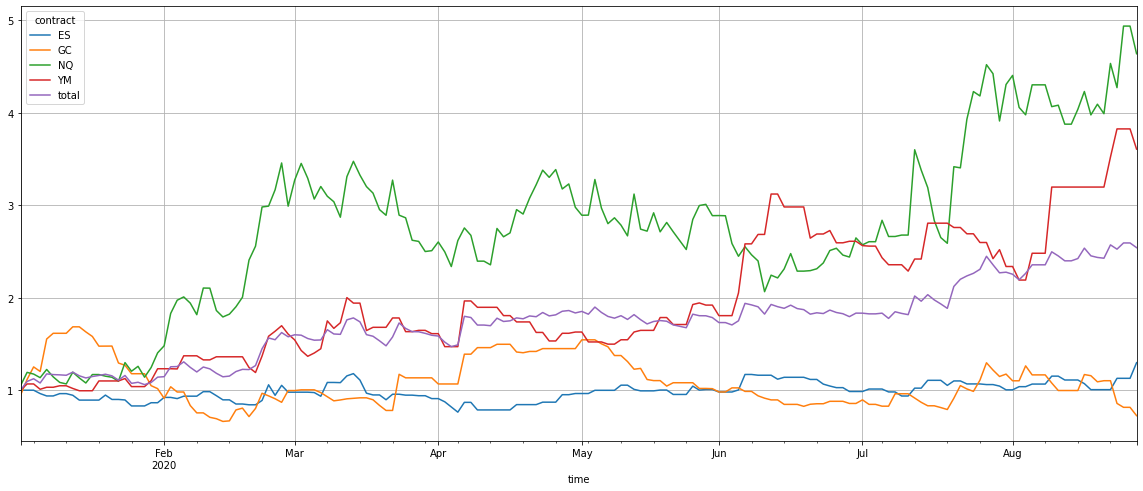

In [18]:
returns_index = (returns_scaled + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(returns_scaled + 1)
log_returns.corr()

contract,ES,GC,NQ,YM,total
contract,,,,,
ES,1.000000,-0.103577,0.180055,0.561053,0.561019
GC,-0.103577,1.000000,0.073142,0.029897,0.512434
NQ,0.180055,0.073142,1.000000,0.126279,0.640336
YM,0.561053,0.029897,0.126279,1.000000,0.643072
total,0.561019,0.512434,0.640336,0.643072,1.000000


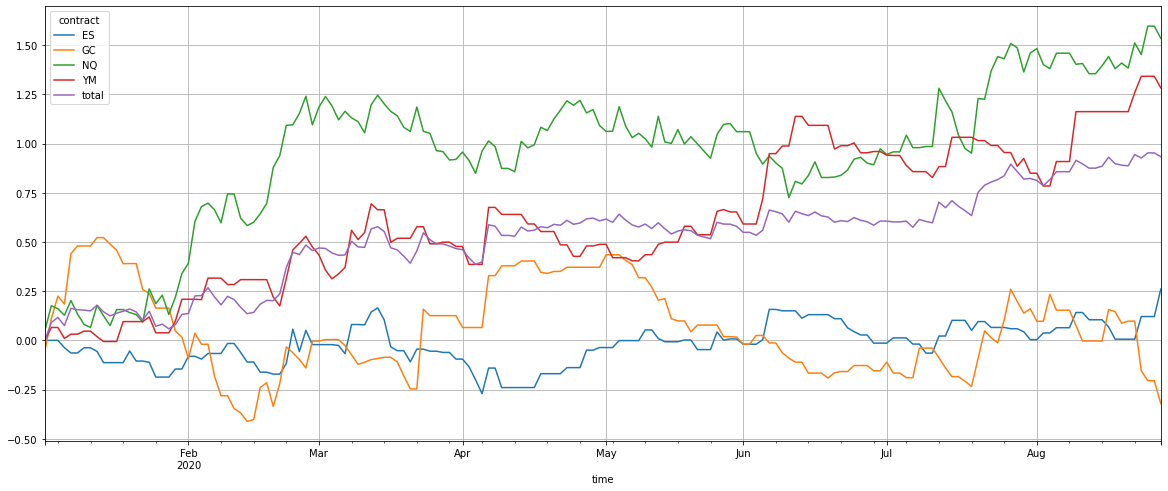

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

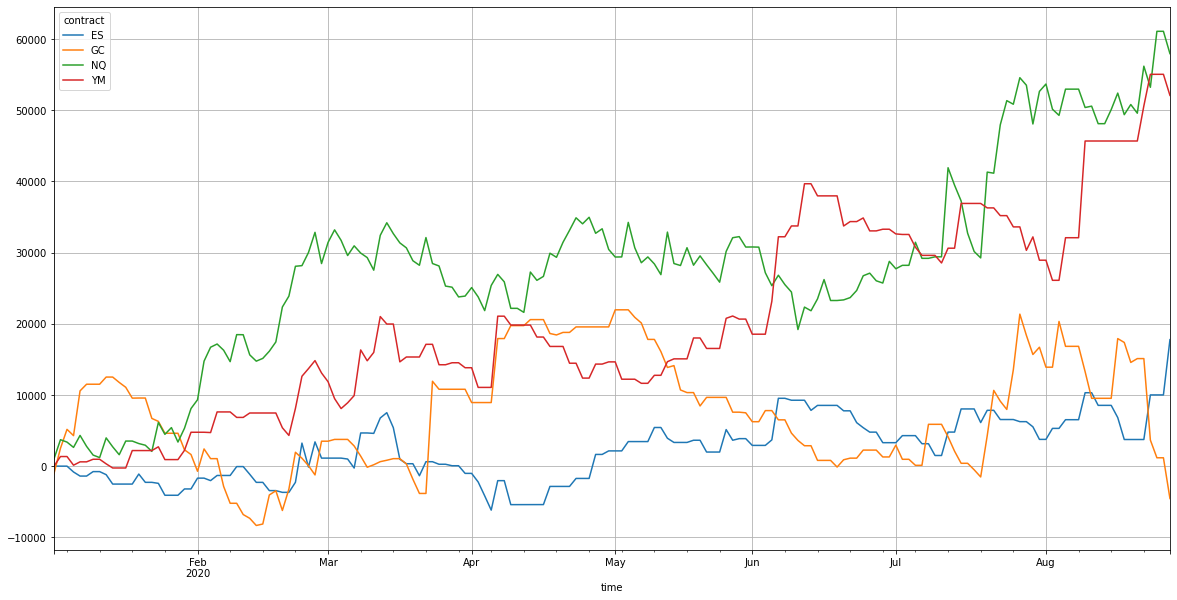

In [21]:
# dollar returns cummulative
by_contract.resample('B').sum().drop('total', axis=1).cumsum().plot(figsize=(20,10), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(returns_scaled[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.464639,-0.375922,8.466075,5.548546,2.921016
Cumulative returns,0.297531,-0.275160,3.637402,2.606212,1.541079
Annual volatility,0.717881,1.256007,1.274297,1.016275,0.634853
Sharpe ratio,0.876308,0.190558,2.369557,2.321151,2.459971
Calmar ratio,1.315361,-0.619367,20.868984,18.620724,16.766851
Stability,0.327806,0.044218,0.565945,0.855752,0.870693
Max drawdown,-0.353241,-0.606946,-0.405677,-0.297977,-0.174214
Omega ratio,1.221246,1.044627,1.506368,1.771740,1.581510
Sortino ratio,1.572191,0.372899,4.659888,5.269443,5.419851
Skew,1.289797,2.373183,1.081032,2.050495,1.593130


In [23]:
#non-scaled returns
stats_non_scaled = pd.DataFrame()
for col in daily.columns:
    stats_non_scaled[col] = perf_stats(returns[col])
stats_non_scaled

,ES,GC,NQ,YM,total
Annual return,0.151861,0.012323,1.022382,0.746759,2.921016
Cumulative returns,0.101306,0.008394,0.617200,0.463301,1.541079
Annual volatility,0.179470,0.314002,0.318574,0.254069,0.634853
Sharpe ratio,0.876308,0.190558,2.369557,2.321151,2.459971
Calmar ratio,1.523087,0.061783,9.940816,9.475807,16.766851
Stability,0.571725,0.028741,0.692901,0.893599,0.870693
Max drawdown,-0.099706,-0.199453,-0.102847,-0.078807,-0.174214
Omega ratio,1.221246,1.044627,1.506368,1.771740,1.581510
Sortino ratio,1.572191,0.372899,4.659888,5.269443,5.419851
Skew,1.289797,2.373183,1.081032,2.050495,1.593130


In [24]:
# monthly returns in percent
log_r = np.log(returns + 1)
monthly_log_returns = log_r.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
monthly_returns = round(monthly_returns, 4) * 100
monthly_returns

contract,ES,GC,NQ,YM,total
time,,,,,
2020-01-31,-3.40,1.95,10.17,5.78,14.11
2020-02-29,3.91,1.25,23.06,7.57,38.24
2020-03-31,-1.27,5.17,-3.43,1.14,1.04
2020-04-30,1.97,7.17,5.27,1.33,15.13
2020-05-31,1.28,-8.20,0.25,4.51,-2.72
2020-06-30,-0.23,-4.06,-1.49,9.19,2.69
2020-07-31,0.69,9.49,15.81,-2.31,24.14
2020-08-31,7.11,-10.12,2.59,12.57,11.66


In [25]:
monthly_returns.total.mean(), monthly_returns.total.median()

(13.036249999999999, 12.885)

In [26]:
monthly_returns.sort_values('total', ascending = False).total

time
2020-02-29    38.24
2020-07-31    24.14
2020-04-30    15.13
2020-01-31    14.11
2020-08-31    11.66
2020-06-30     2.69
2020-03-31     1.04
2020-05-31    -2.72
Name: total, dtype: float64

In [27]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES        10.0
GC         1.0
NQ        62.0
YM        46.0
total    154.0
dtype: float64

In [28]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-08-11 20:36:30,YM,SELL,27900.0,10457.40
2020-07-21 00:44:00,NQ,SELL,10935.0,10381.60
2020-04-07 02:34:00,GC,SELL,1724.7,8175.16
2020-03-24 11:58:30,GC,SELL,1680.3,8045.16
2020-08-18 16:06:00,GC,SELL,2011.3,7630.32
...,...,...,...,...
2020-08-03 01:38:00,GC,SELL,1994.9,-2549.68
2020-08-19 21:41:30,ES,SELL,3374.5,-2637.60
2020-07-29 14:13:30,YM,BUY,26372.0,-2667.60


In [29]:
daily.sort_values('total', ascending=False)

contract,ES,GC,NQ,YM,total
time,,,,,
2020-04-07,4140.92,8992.22,1557.22,10008.84,24699.20
2020-07-21,1721.09,5788.02,12054.32,-625.86,18937.57
2020-07-13,3290.16,-1751.46,12518.22,2074.40,16131.32
2020-06-05,5841.60,-1299.60,1474.88,9061.90,15078.78
2020-02-24,1410.77,5173.36,4192.62,3788.18,14564.93
...,...,...,...,...,...
2020-08-19,-3079.80,-545.64,-3033.92,0.00,-6659.36
2020-01-27,-1675.16,-1669.66,-1669.40,-1796.06,-6810.28
2020-07-30,-723.73,-2694.36,-5448.48,1889.76,-6976.81


In [30]:
# gaining vs. losing days in percent
results_dict = {}
_daily = daily[daily['total'] != 0]
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c].count()
    loss = _daily[_daily[c]<0][c].count()
    total = _daily[_daily[c]!=0][c].count()
    results_dict[c] = {'gain': round(gain/total,2), 
                       'loss': round(loss/total,2), 
                       }
frequency = pd.DataFrame(results_dict)
frequency

,ES,GC,NQ,YM,total
gain,0.42,0.37,0.48,0.51,0.43
loss,0.58,0.63,0.52,0.49,0.57


In [31]:
# daily gain/loss ratio
results = {}
for c in _daily.columns:
    gain = _daily[_daily[c]>0][c]
    loss = -_daily[_daily[c]<0][c]
    results[c] = round(gain.mean()/loss.mean(),2)
ratios = pd.Series(results)
ratios

ES       1.77
GC       1.62
NQ       1.52
YM       1.67
total    1.94
dtype: float64

In [32]:
# daily EV in stop-loss units
r = {}
for i in ratios.iteritems():
    r[i[0]] = frequency[i[0]].gain * i[1] - frequency[i[0]].loss
ev = pd.Series(r)
ev

ES       0.1634
GC      -0.0306
NQ       0.2096
YM       0.3617
total    0.2642
dtype: float64

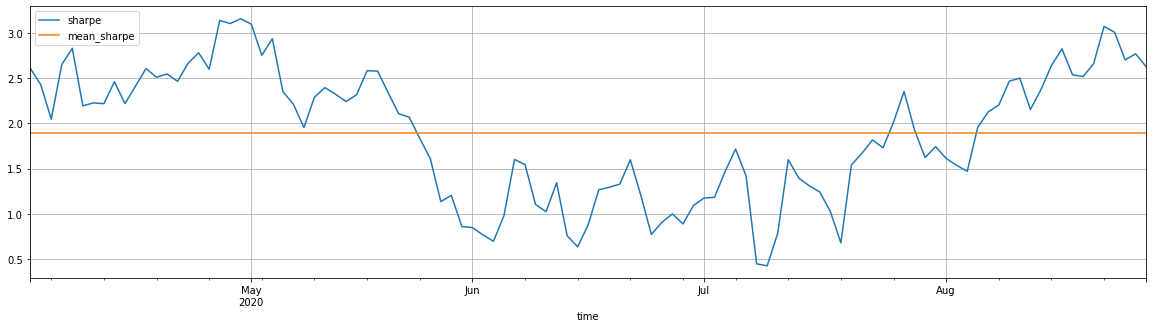

In [33]:
plot_rolling_sharpe(returns.total, 3)

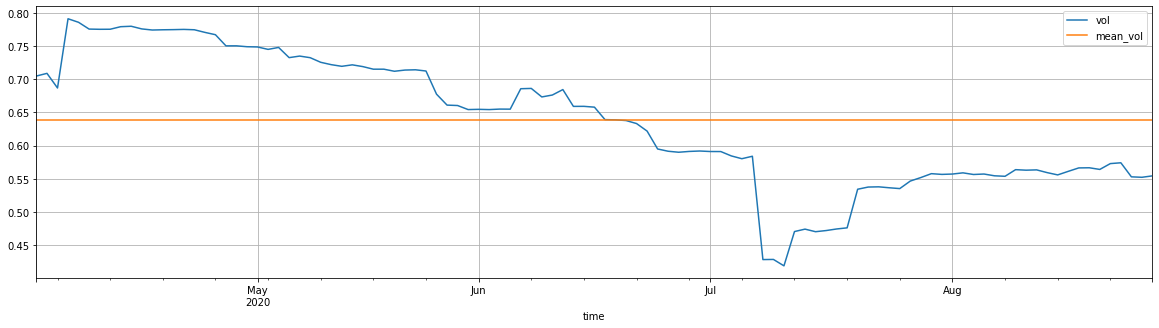

In [34]:
plot_rolling_vol(returns.total, 3)